In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!unzip "/CT_2.zip" -d "/content/"

In [ ]:
!unzip "/CT_Cut.zip" -d "/content/"

In [ ]:
image_size = (500, 500)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CT_2",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.4,
    subset="training",
    seed=1337,
    image_size=image_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CT_2",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.4,
    subset="validation",
    seed=1337,
    image_size=image_size,
)

Found 5189 files belonging to 2 classes.
Using 3114 files for training.
Found 5189 files belonging to 2 classes.
Using 2075 files for validation.


In [ ]:
path="/content/CT_Cut/Evaluate"
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
)

Found 200 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.Rescaling(1./255),
     layers.experimental.preprocessing.RandomFlip(),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom((-0.1,0.1),(-0.1,0.1), fill_mode='nearest'),
    ]
)

In [ ]:
inputA=layers.Input(shape=(500,500,3))

rohA=data_augmentation(inputA)

In [ ]:
base_modelA=tf.keras.applications.NASNetLarge(include_top=False, weights='imagenet', input_tensor=rohA)
base_modelB=tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=rohA)
base_modelC=tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=rohA)
base_modelD=tf.keras.applications.Xception(include_top=False, weights="imagenet", input_tensor=rohA)

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
base_modelA.trainable=False
base_modelB.trainable=False
base_modelC.trainable=False
base_modelD.trainable=False

In [ ]:
loutput1 = base_modelA.output

In [ ]:
loutput2 = base_modelB.output

In [ ]:
loutput3 = base_modelC.output

In [ ]:
loutput4 = base_modelD.output

In [ ]:
gap1=layers.GlobalAveragePooling2D()(loutput1)
gap2=layers.GlobalAveragePooling2D()(loutput2)
gap3=layers.GlobalAveragePooling2D()(loutput3)
gap4=layers.GlobalAveragePooling2D()(loutput4)

In [ ]:
concat=layers.Concatenate()([gap1, gap2, gap3, gap4])

In [ ]:
bn_layer_concat = layers.BatchNormalization(name='bn_layer_concat')(concat)

In [ ]:
x = layers.Dense(64, activation=tf.nn.swish)(bn_layer_concat)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(32, activation=tf.nn.swish, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.2)(x)

In [ ]:
output_layer=layers.Dense(2,activation="softmax")(x)

In [ ]:
model=tf.keras.Model(inputA,output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 500, 500, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 249, 249, 96) 2592        sequential[0][0]                 
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 249, 249, 96) 384         stem_conv1[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
             keras.metrics.CategoricalAccuracy(name='accuracy'),
             keras.metrics.Precision(0.7),
             keras.metrics.Recall(0.7),
    ],
)

In [ ]:
epochs = 15
history=model.fit(
       train_ds ,epochs=epochs, validation_data=val_ds, callbacks=callback
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
98/98 [==============================] - 690s 6s/step - loss: 0.3896 - accuracy: 0.8475 - precision: 0.9058 - recall: 0.7322 - val_loss: 0.5804 - val_accuracy: 0.6742 - val_precision: 0.9099 - val_recall: 0.3990
Epoch 2/15
98/98 [==============================] - 597s 6s/step - loss: 0.2788 - accuracy: 0.8995 - precision: 0.9469 - recall: 0.8182 - val_loss: 0.4071 - val_accuracy: 0.8704 - val_precision: 0.9666 - val_recall: 0.6270
Epoch 3/15
98/98 [==============================] - 596s 6s/step - loss: 0.2449 - accuracy: 0.9117 - precision: 0.9515 - recall: 0.8378 - val_loss: 0.2849 - val_accuracy: 0.9186 - val_precision: 0.9668 - val_recall: 0.7860
Epoch 4/15
98/98 [==============================] - 597s 6s/step - loss: 0.2176 - accuracy: 0.9213 - precision: 0.9600 - recall: 0.8622 - val_loss: 0.2351 - val_accuracy: 0.9234 - val_precision: 0.9649 - val_recall: 0.8357
Epoch 5/15
98/98 [==============================] - 596s 6s/step - loss: 0.1940 - accuracy: 0.9377 - precisi

In [ ]:
model.save('/model-full.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import matplotlib.pyplot as plt

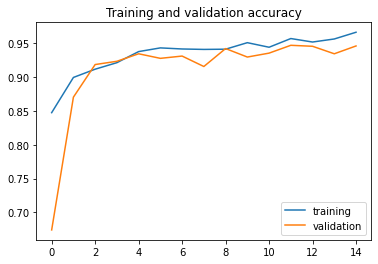

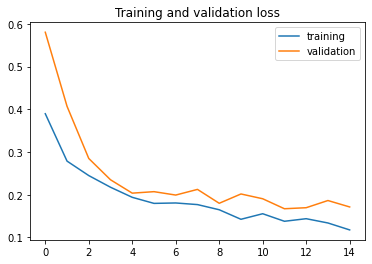

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc,label='training')
plt.plot(epochs, val_acc, label='validation')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
remodel = tf.keras.models.load_model('/model-full.h5')

In [ ]:
remodel.evaluate(test_ds)

7/7 [==============================] - 89s 8s/step - loss: 0.1882 - accuracy: 0.9500 - precision: 0.9637 - recall: 0.9300


[0.1882167011499405, 0.949999988079071, 0.9637305736541748, 0.9300000071525574]

In [ ]:
im = #path of the image

In [ ]:
img = tf.keras.preprocessing.image.load_img(im, target_size=(500, 500))
image = tf.keras.preprocessing.image.img_to_array(img)
image = tf.expand_dims(image, 0)

remodel.predict(image)